In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image_path = "/home/haleelsada/Downloads/GSOC25/RENNAISSENCE/images1/image1.jpg"


### The algorithm idea

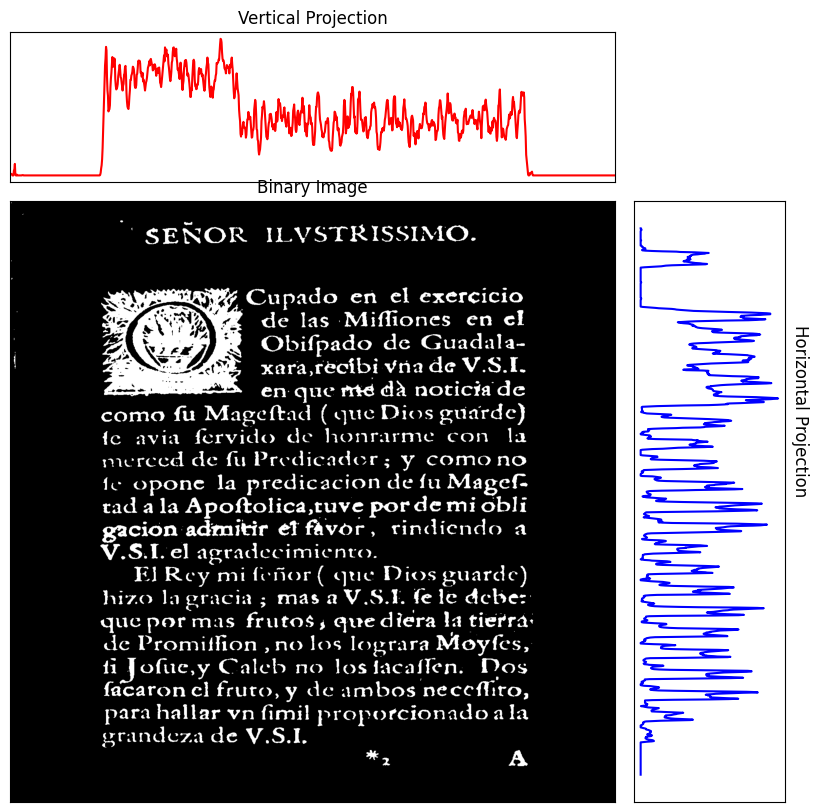

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_hists_image(image_path):
    # Load image and convert to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply binary thresholding to extract text areas
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Compute vertical and horizontal projection profiles
    vertical_projection = np.sum(binary, axis=0)  
    horizontal_projection = np.sum(binary, axis=1) 

    # Normalize projections for better visualization
    vertical_projection = vertical_projection / np.max(vertical_projection) * image.shape[1]
    horizontal_projection = horizontal_projection / np.max(horizontal_projection) * image.shape[0]

    # Create a figure with custom layout
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.05, hspace=0.05)

    # Vertical projection plot (on top)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(vertical_projection, color='red')
    ax1.set_xlim([0, image.shape[1]])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Vertical Projection")

    # Main image display
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.imshow(binary, cmap='gray', aspect='auto')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Binary Image")

    # Horizontal projection plot (on the right)
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(horizontal_projection, np.arange(len(horizontal_projection)) , color='blue')
    ax3.invert_yaxis()
    ax3.set_yticks([])
    ax3.set_xticks([])
    ax3.set_title("Horizontal Projection", rotation=-90, y=0.5, x=1.1)

    plt.show()

show_hists_image(image_path)


### First trial

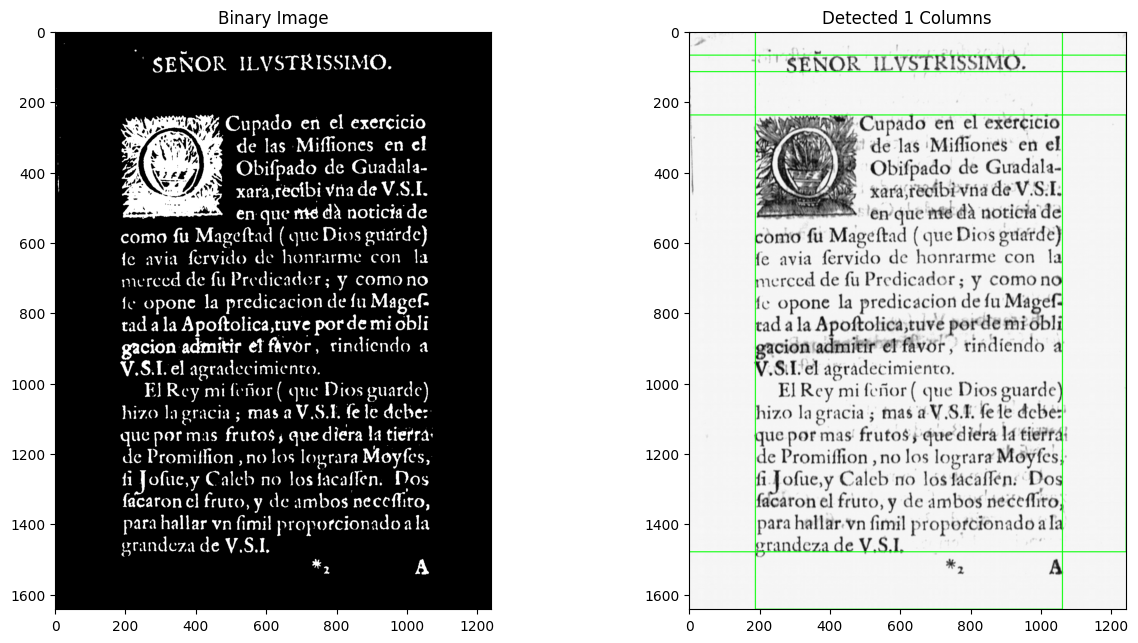

Number of columns detected: 1


In [28]:
def detect_text_columns(image_path):
    # Load image and convert to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    height, width = image.shape[:2]
    # Apply binary thresholding (simple method to separate text from background)
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Find vertical and horizontal projection profiles
    vertical_projection = np.sum(binary, axis=0)  # Summing along Y-axis (columns)
    horizontal_projection = np.sum(binary, axis=1)  # Summing along X-axis (rows)

    # Normalize projections for visualization
    vertical_projection = vertical_projection / np.max(vertical_projection)
    horizontal_projection = horizontal_projection / np.max(horizontal_projection)

    # Detect column separations
    threshold = 0.1  # A low value indicates blank spaces
    column_gaps = vertical_projection < threshold 
    column_changes = np.diff(column_gaps.astype(int))

    # Find where columns start and end
    column_starts = np.where(column_changes == -1)[0]  # Text starts
    column_ends = np.where(column_changes == 1)[0]  # Text ends
    if len(column_starts!=len(column_ends)) and column_starts[0]>column_ends[0]:
        column_ends = np.delete(column_ends,0)
    column_startsn,column_endsn = column_starts,column_ends

    linelength = image.shape[0]/30
    for ci in range(len(column_starts)-1):
        #print(abs(row_ends[ri]-row_starts[ri+1]))
        if abs(column_ends[ci]-column_starts[ci+1])<linelength:
            column_endsn = np.delete(column_endsn, np.where(column_endsn == column_ends[ci]))
            column_startsn = np.delete(column_startsn,np.where(column_startsn==column_starts[ci+1]))
    # Determine number of columns
    num_columns = len(column_starts)
    
    # Draw detected columns on the original image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for start, end in zip(column_startsn, column_endsn):
        cv2.rectangle(output_image, (start, 0), (end, image.shape[0]), (0, 255, 0), 2)

    # Detect row separations
    threshold = 0.1 # A low value indicates blank spaces
    row_gaps = horizontal_projection < threshold
    row_changes = np.diff(row_gaps.astype(int))

    # Find where rows start and end
    row_starts = np.where(row_changes == -1)[0]  # Text starts
    row_ends = np.where(row_changes == 1)[0]  # Text ends
    if len(row_starts!=len(row_ends)) and row_starts[0]>row_ends[0]:
        row_ends = np.delete(row_ends,0)
    row_startsn,row_endsn = row_starts,row_ends

    linelength = image.shape[1]/30
    for ri in range(len(row_starts)-1):
        #print(abs(row_ends[ri]-row_starts[ri+1]))
        if abs(row_ends[ri]-row_starts[ri+1])<linelength:
            row_endsn = np.delete(row_endsn, np.where(row_endsn == row_ends[ri]))
            row_startsn = np.delete(row_startsn,np.where(row_startsn==row_starts[ri+1]))
    # Determine number of rows
    num_rows = len(row_starts)
    
    
    # Draw detected rows on the original image
    #output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for start, end in zip(row_startsn, row_endsn):
        cv2.rectangle(output_image, (0, start), (image.shape[1],end), (0, 255, 0), 2)

    # Show results
    plt.figure(figsize=(15, 7.5))
    plt.subplot(1, 2, 1)
    plt.imshow(binary, cmap="gray")
    plt.title("Binary Image")

    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title(f"Detected {num_columns} Columns")
    plt.show()

    return num_columns

# Example usage
columns_detected = detect_text_columns(image_path)
print(f"Number of columns detected: {columns_detected}")

## Final method

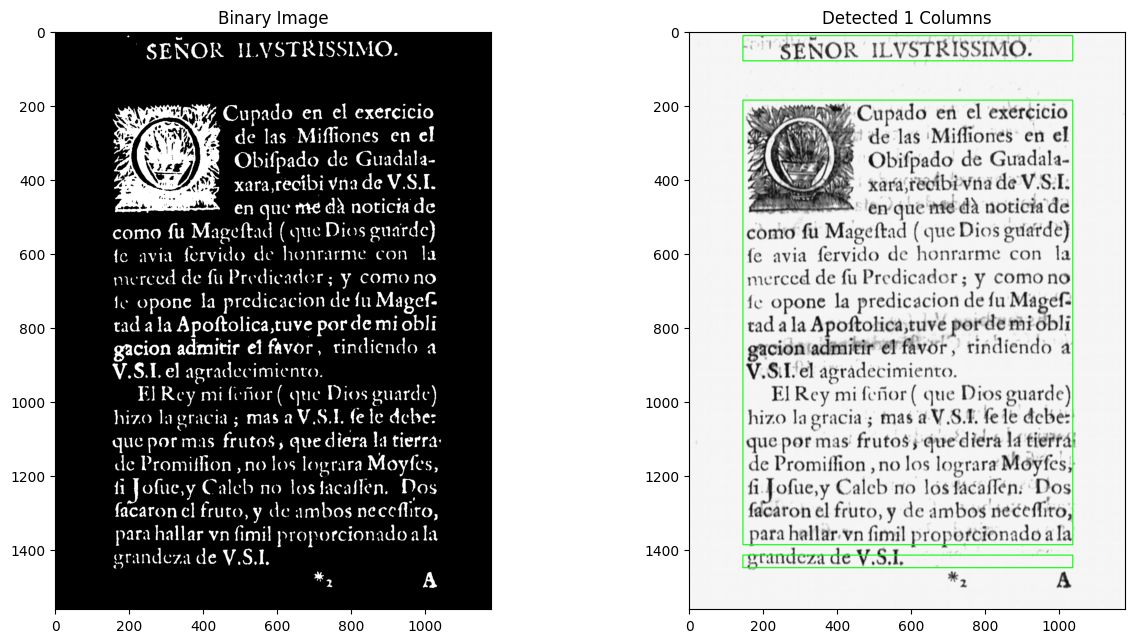

Number of columns detected: 1


In [64]:
def detect_text_columns(image_path):
    # Load image and convert to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    height, width = image.shape[:2]
    
    # Calculate crop margins (5% from each side)
    crop_x = int(width * 0.025)
    crop_y = int(height * 0.025)
    margin = int(width * 0.005)

    # Crop the image
    image = image[crop_y:height-crop_y, crop_x:width-crop_x]

    # Apply binary thresholding (simple method to separate text from background)
    _, binary = cv2.threshold(image, 140, 255, cv2.THRESH_BINARY_INV)

    # Find vertical and horizontal projection profiles
    vertical_projection = np.sum(binary, axis=0)  # Summing along Y-axis (columns)
    horizontal_projection = np.sum(binary, axis=1)  # Summing along X-axis (rows)

    # Normalize projections for visualization
    vertical_projection = vertical_projection / np.max(vertical_projection)
    horizontal_projection = horizontal_projection / np.max(horizontal_projection)

    # Detect column separations
    threshold = 0.1  # A low value indicates blank spaces
    column_gaps = vertical_projection < threshold 
    column_changes = np.diff(column_gaps.astype(int))

    # Find where columns start and end
    column_starts = np.where(column_changes == -1)[0]  # Text starts
    column_ends = np.where(column_changes == 1)[0]  # Text ends
    if len(column_starts!=len(column_ends)) and column_starts[0]>column_ends[0]:
        column_ends = np.delete(column_ends,0)
    column_startsn,column_endsn = column_starts,column_ends

    linelength = image.shape[0]/30
    #print(linelength)
    for ci in range(len(column_starts)-1):
        #print(abs(row_ends[ri]-row_starts[ri+1]))
        if abs(column_ends[ci]-column_starts[ci+1])<linelength:
            column_endsn = np.delete(column_endsn, np.where(column_endsn == column_ends[ci]))
            column_startsn = np.delete(column_startsn,np.where(column_startsn==column_starts[ci+1]))
    # Determine number of columns
    num_columns = len(column_starts)
    
 
    # Detect row separations
    threshold = 0.3 # A low value indicates blank spaces
    row_gaps = horizontal_projection < threshold
    row_changes = np.diff(row_gaps.astype(int))

    # Find where rows start and end
    row_starts = np.where(row_changes == -1)[0]  # Text starts
    row_ends = np.where(row_changes == 1)[0]  # Text ends
    if len(row_starts!=len(row_ends)) and row_starts[0]>row_ends[0]:
        row_ends = np.delete(row_ends,0)
    row_startsn,row_endsn = row_starts,row_ends

    linelength = image.shape[1]/30
    #print(linelength)
    for ri in range(len(row_starts)-1):
        #print(abs(row_ends[ri]-row_starts[ri+1]))
        if abs(row_ends[ri]-row_starts[ri+1])<linelength:
            row_endsn = np.delete(row_endsn, np.where(row_endsn == row_ends[ri]))
            row_startsn = np.delete(row_startsn, np.where(row_startsn==row_starts[ri+1]))
    # Determine number of rows
    num_rows = len(row_starts)
    
    for i in range(len(row_endsn)):
        if (row_startsn[i]-row_endsn[i])<linelength:
            row_startsn[i],row_endsn[i] = row_startsn[i]-margin,row_endsn[i]+2*margin
   
    # Draw detected rows on the original image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for i in range(len(row_startsn)):
        for j in range(len(column_startsn)):
            try:
                cv2.rectangle(output_image, (column_startsn[j]-2*margin, row_startsn[i]-2*margin), (column_endsn[j]+margin, row_endsn[i]), (0, 255, 0), 2)
            except:
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
                cv2.rectangle(output_image, (column_startsn[j], row_startsn[i]), (column_endsn[j], row_endsn[i]), (0, 255, 0), 2)
    # Show results
    plt.figure(figsize=(15, 7.5))
    plt.subplot(1, 2, 1)
    plt.imshow(binary, cmap="gray")
    plt.title("Binary Image")

    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title(f"Detected {num_columns} Columns")
    plt.show()

    return num_columns

# Example usage
columns_detected = detect_text_columns(image_path)
print(f"Number of columns detected: {columns_detected}")

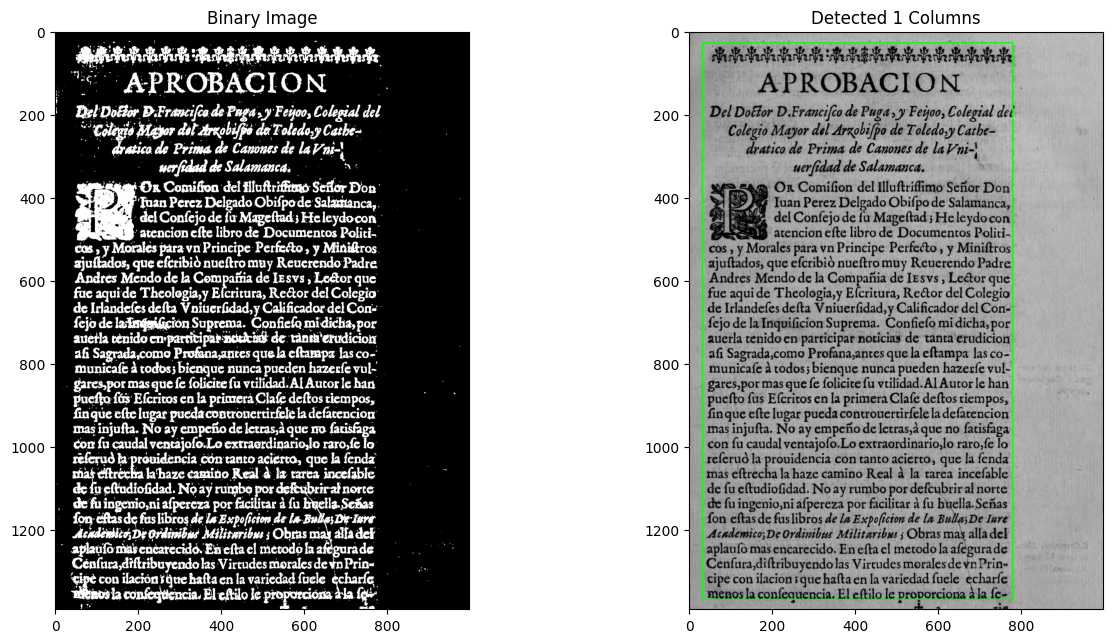

1

In [61]:
columns_detected = detect_text_columns("/home/haleelsada/Downloads/GSOC25/RENNAISSENCE/images1/image14.jpg")
columns_detected

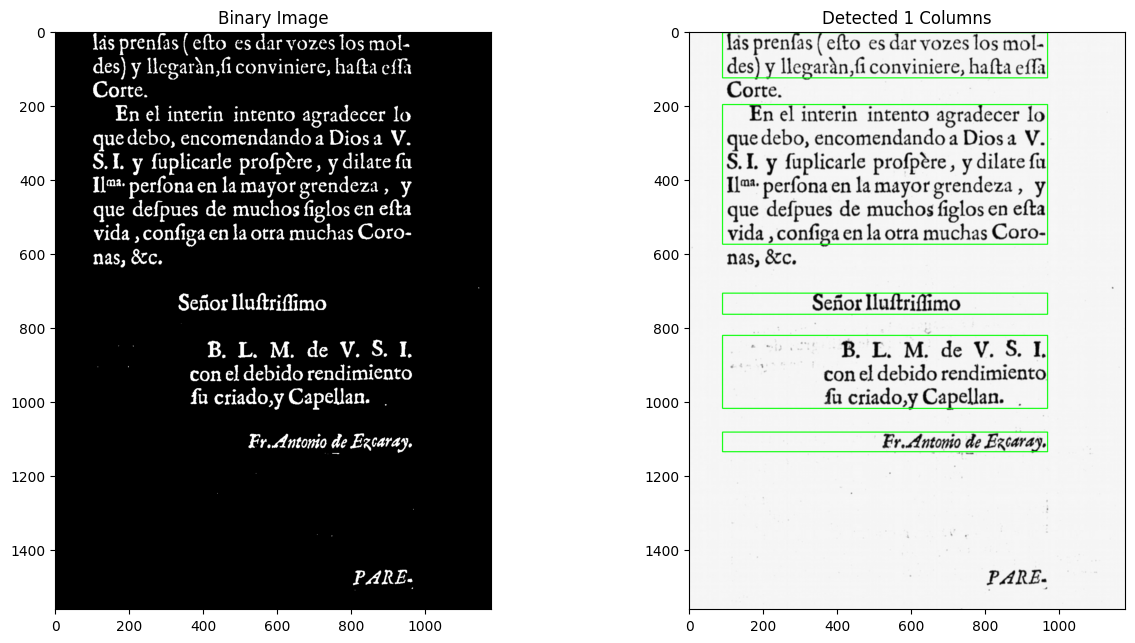

1

In [65]:
columns_detected = detect_text_columns("/home/haleelsada/Downloads/GSOC25/RENNAISSENCE/images1/image11.jpg")
columns_detected